# I. Introduction

## Background

Stock price is influenced by many factors. One of the most crucial aspects is public sentiment of stocks. For gaining much money in the stock market, we need to understand the information spreading in trader's minds. One of the most influential source is stock news that we need to catch the signal immediately.

## Objective

This project is developed for helping traders to understand a lot of news published every minutes. This project will classify news based on their sentiment namely, Positive, Negative and Neutral.

## Dataset Background

Data is extracted by Finnhub API within 90 days, encompassing headline and summary.

# II. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import string
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Lambda
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# III. Data Loading

In [2]:
# Load data
df=pd.read_csv('djia_news.csv')
df

,date,symbol,headline,summary,url,sentiment_label
0,2026-01-30 23:02:41,AAPL,"Dividend Champion, Contender, And Challenger H...",NaN,https://finnhub.io/api/news?id=31f1258df7988e0...,NEUTRAL
1,2026-01-30 22:51:38,AAPL,"Stock Market Today, Jan. 30: Apple Advances Af...",Apple’s earnings confirmed resilient demand an...,https://finnhub.io/api/news?id=1abb5cd929da653...,POSITIVE
2,2026-01-30 22:45:34,AAPL,"Stock Market Today, Jan. 30: Gold Plunges As D...",Gold’s record plunge as precious metals and gr...,https://finnhub.io/api/news?id=390b29df283f4a5...,NEUTRAL
3,2026-01-30 22:14:00,AAPL,B. Riley Cuts Skyworks (SWKS) Target as Androi...,"Skyworks Solutions, Inc. (NASDAQ:SWKS) is incl...",https://finnhub.io/api/news?id=78293bb01b3af77...,NEUTRAL
4,2026-01-30 22:13:25,AAPL,"Stocks to Watch Friday Recap: Apple, Sandisk, ...",↗️ Apple (AAPL): The company posted blowout iP...,https://finnhub.io/api/news?id=4f1407e74c80e7a...,NEUTRAL
...,...,...,...,...,...,...
7009,2026-01-13 18:47:39,WMT,Sector Update: Tech Stocks Mixed Tuesday After...,"Tech stocks were mixed Tuesday afternoon, with...",https://finnhub.io/api/news?id=963ccf908015e1f...,NEUTRAL
7010,2026-01-13 18:42:16,WMT,Walmart Drone Delivery Expansion Could Reach 4...,The Wing-powered service is expected to roll o...,https://finnhub.io/api/news?id=95121c23dce309d...,POSITIVE
7011,2026-01-13 18:29:57,WMT,"JPMorgan stock will bounce back, Jim Cramer says",CNBC's Jim Cramer reviewed Tuesday's market ac...,https://finnhub.io/api/news?id=0ac138cf4ddf911...,POSITIVE
7012,2026-01-13 17:52:02,WMT,The Big Picture: Thoughts On Oil And AI 'Cross...,Avoid false market narratives in 2026: why Exx...,https://finnhub.io/api/news?id=dfe0b12d41ba285...,NEUTRAL


# IV. Feature Engineering

In [3]:
# Data Preprocessing
df=df.dropna()
df['text']=df['headline']+" "+df['summary']
df=df.drop(columns=['url','symbol', 'date','headline','summary'])

# Target Transformation
df['label'] = df['sentiment_label'].replace({'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2})
df=df.drop(columns='sentiment_label')

C:\Users\DELL\AppData\Local\Temp\ipykernel_22748\401396559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['headline']+" "+df['summary']
C:\Users\DELL\AppData\Local\Temp\ipykernel_22748\401396559.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['sentiment_label'].replace({'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2})


Preprocessing data before implementing to the model

In [4]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # Puntuaction
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub(r'\d+', '', text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Define Stopwords
  stpwds_id = list(set(stopwords.words('english')))

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Lemmatizer  
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)
  return text

On the feature engineering, we clean and transform the data such as:
1. Transform all case to be lower case
2. Remove newline
3. Remove whitespace
4. Remove punctuation
5. Remove Non-letter symbol
6. Tokenize text to be tokens
7. Find and remove stopwords
8. Lemmatize the tokens to be clean from suffix
9. Regroup again the tokens

# V. Exploratory Data Analysis

## 1. News Sentiment Proportion

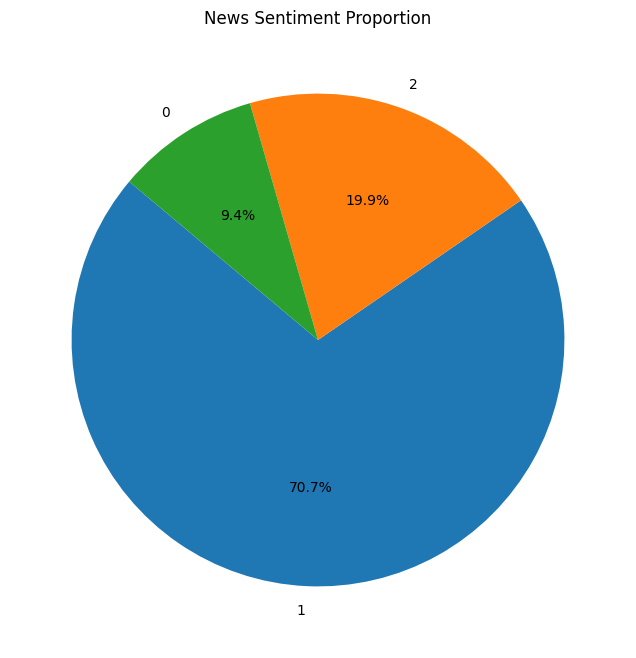

In [108]:
# Create eda dataframe
df_eda = df.copy()
df_eda.text = df_eda.text.apply(lambda x: text_preprocessing(x))
df_eda['text_processed'] = df_eda['text'].apply(lambda x: text_preprocessing(x))

# Count of each category
counts = df_eda['label'].value_counts()

# 2. Membuat Pie Chart
plt.figure(figsize=(8, 8))
counts.plot(kind='pie', 
                autopct='%1.1f%%',
                startangle=140)
plt.title('News Sentiment Proportion')
plt.ylabel('')
plt.show()

From the information above, we can see that "Neutral news is the most frequent published. If we want to see considerable stock's movement, it could happen when "Positive" and "Negative" news are published. For modelling, we should consider to handle this imbalanced data.

## 2. Text Length

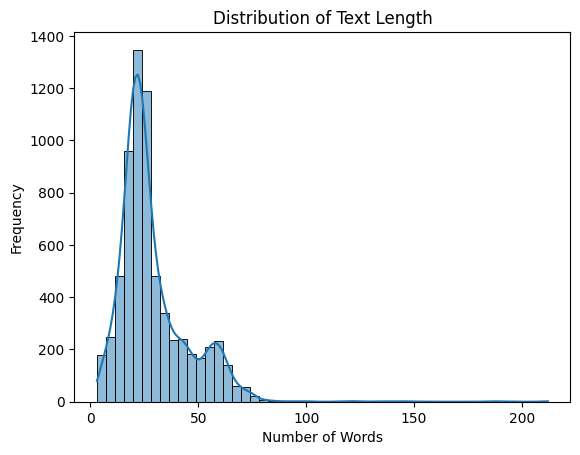

In [109]:
# Split word for text length
df_eda['text_length'] = df_eda['text'].str.split().apply(len)

# Text Length Distribution
plt.figure()
sns.histplot(df_eda['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

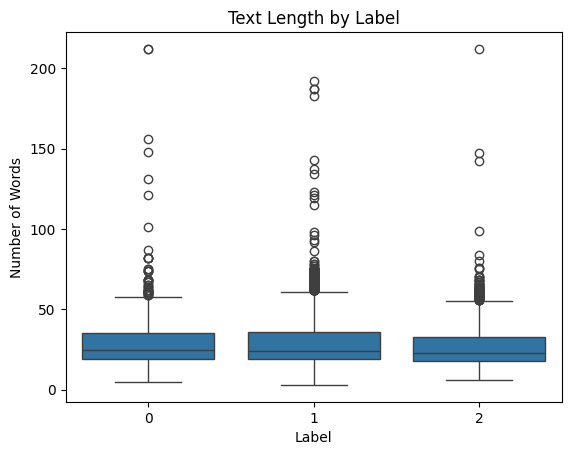

In [110]:
# Text Length by Label
plt.figure()
sns.boxplot(x='label', y='text_length', data=df_eda)
plt.title('Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Number of Words')
plt.show()

Most of data are ranging from 0-50 words. It could be not too long because those are just headline and summary.

## 3. Most Frequent Words

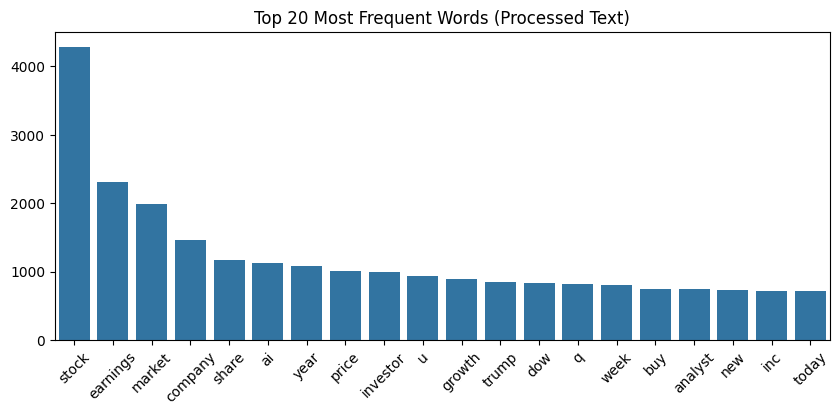

In [111]:
# Mosth Frequent Words
all_words = " ".join(df_eda['text_processed']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,4))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words (Processed Text)')
plt.show()

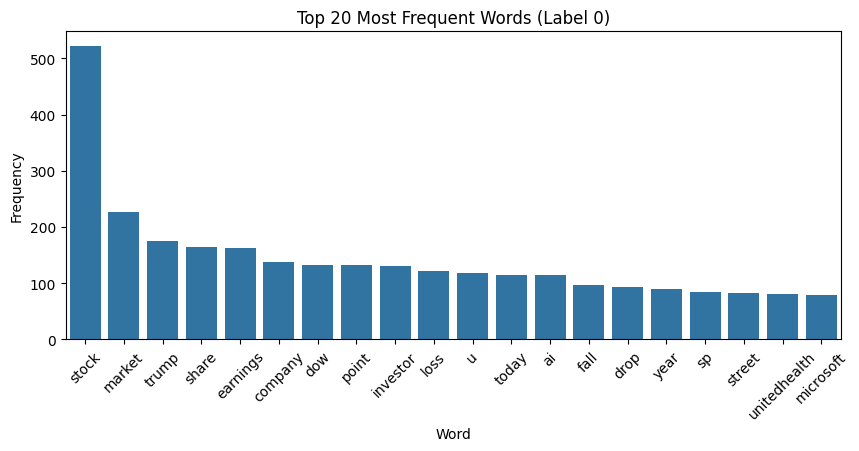

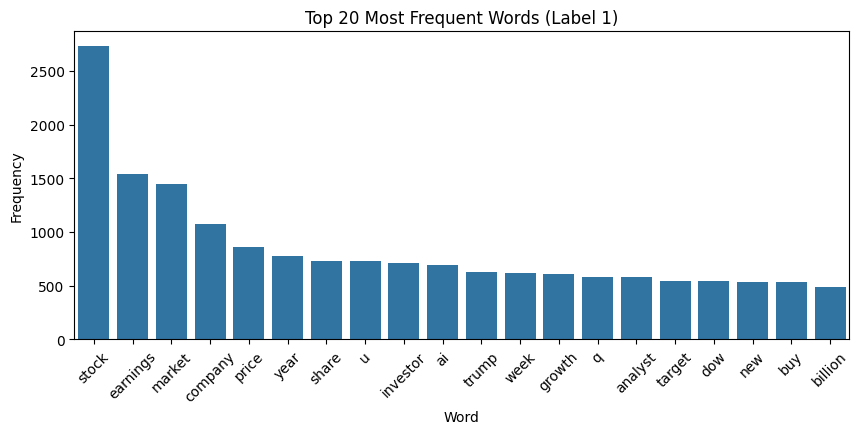

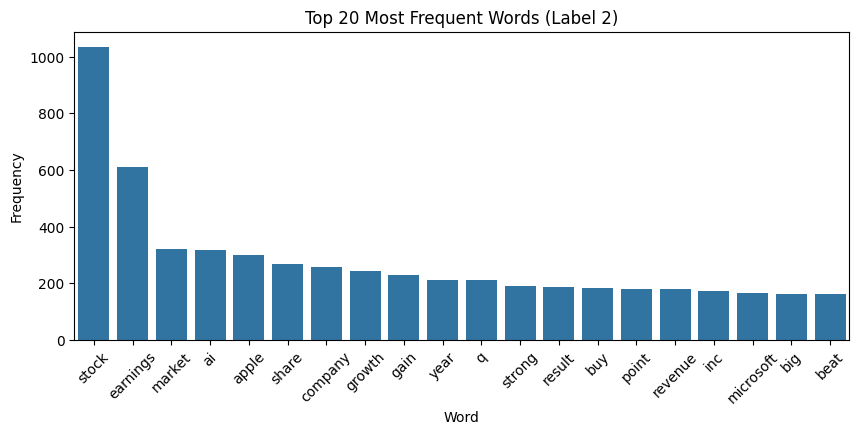

In [ ]:
# Finding most frequent words on each label
TOP_N = 20
labels = sorted(df_eda['label'].unique())

for lbl in labels:
    # Combine all processed text for the label
    words = " ".join(
        df_eda[df_eda['label'] == lbl]['text_processed']
    ).split()
    
    word_freq = Counter(words)
    most_common = word_freq.most_common(TOP_N)
    
    # Convert to dataframe for plotting
    vocab_data = pd.DataFrame(most_common, columns=['word', 'count'])
    
    plt.figure(figsize=(10,4))
    sns.barplot(
        data=vocab_data,
        x='word',
        y='count'
    )
    plt.title(f'Top {TOP_N} Most Frequent Words (Label {lbl})')
    plt.xticks(rotation=45)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.show()


Overall, the common words, stock, earnings and market, are still dominant. Subsequently, at negative news, there are keywords of negative issue, namely, "loss", "drop", "fall". In the flip side, positive news also have some keywords, "growth", "gain", "strong", "buy", "beat".

In [5]:
# Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(df.text,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)
y_train

Train Size :  (5206,)
Val Size   :  (579,)
Test Size  :  (1021,)


1400    1
1476    1
6560    1
54      0
1491    0
       ..
1664    0
5190    1
3545    2
3794    0
785     0
Name: label, Length: 5206, dtype: int64

The dataset was splitted to be 3 categories, train, validation and test set

In [6]:
# Change Target to One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

The target was transformed using one hot encoder so that those can be processed on the model

In [7]:
# Get Vocabularies
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_train_vec

<5206x12906 sparse matrix of type '<class 'numpy.int64'>'
	with 176290 stored elements in Compressed Sparse Row format>

The train set was vectorized to get the vocabulary to define total vocab on next step

In [8]:
# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  12906
Maximum Sentence Length :  344 tokens


The total of vocab and maximum sentence length would be implemented on vectorization step

In [9]:
def preprocessing_layer(text_tensor):
    def _inner_py_func(text_b):
        text = text_b.decode('utf-8')
        return text_preprocessing(text)

    result = tf.numpy_function(_inner_py_func, [text_tensor], tf.string)
    return result

The function waa used for preprocessing to be suitable data structure.

In [10]:
# Text Vectorization
text_vectorization = TextVectorization(
    max_tokens=total_vocab,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_sen_len
)

# Vectorize Result
text_vectorization.adapt(X_train)

# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

Preparing the vectorization and embedding before defining model layer. Vectorization is used for separating the text to be tokens and embedding is used for creating "meaning" from each token to know the correlation with the text context.

# VI. ANN Training

## A. Model Definition

In [120]:
## Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture - Sequential API
model_lstm_1 = Sequential()
model_lstm_1.add(Input(shape=(), dtype=tf.string))
model_lstm_1.add(Lambda(lambda x: tf.reshape(tf.map_fn(preprocessing_layer, x, fn_output_signature=tf.string), [-1])))
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))
model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The first model is used a few layer namely:
1. Implementing preprocessing layer
2. Vectorizing for separating text to tokens
3. Embbeding for defining "meaning" of each tokens based on their interaction each other
4. The first hidden layer using LSTM with 16 neurons 
5. Droputing the result of first hidden layer as much as 10 percent
6. The second hidden layer using LSTM with 8 neurons 
7. Droputing the result of second hidden layer as much as 10 percent
8. Activation layer for multiclass prediction using softmax
9. For the loss calculation, we used categorical crossentropy with adam's optimizer. And for the evaluation metric we used accuracy

## B. Model Training

In [ ]:
## Generate batch dataset
X_train_array = np.array(X_train, dtype=str)
X_val_array = np.array(X_val, dtype=str)
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_array, y_train_ohe)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_array, y_val_ohe)).batch(batch_size)

# Training
model_lstm_1_hist = model_lstm_1.fit(train_dataset, validation_data=val_dataset, epochs=20)

## C. Model Evaluation

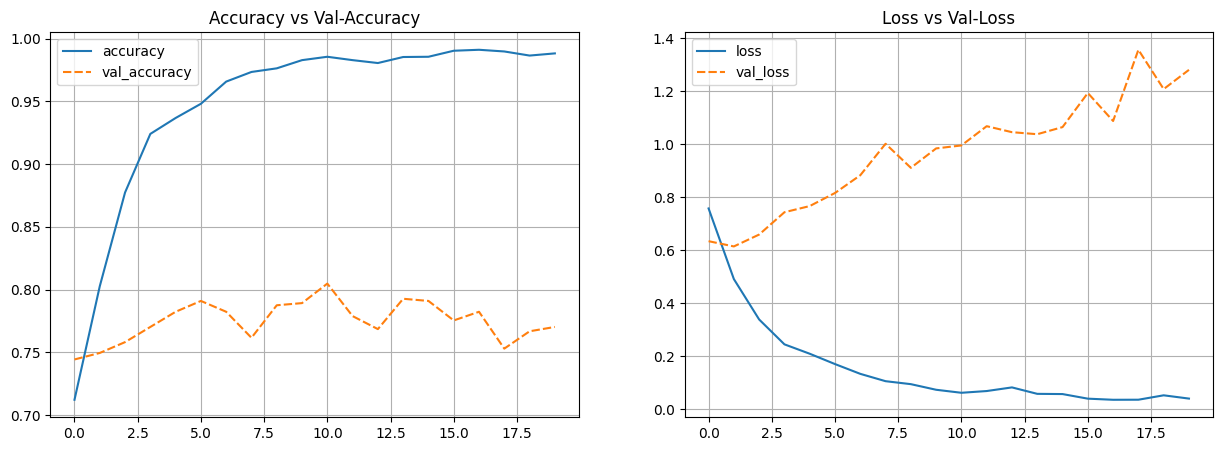

In [122]:
# Plot Training Results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

From the information above, we can conclude the model is overfitting. It has very high accuracy and very low loss with the far gap with the validation set.
It can be happened since the size of trained data is very small with many neurons in each hidden layer. The another reason is the dropout percentage is too low generating overfitting. The solution for small size dataset as this project, we could try transfer learning for bigger knowledge for understanding each token and use early stopping for helping to avoid overfitting.

The conclusion of this model is, we can interprete the prediction well because the overfitting is too far between train and validation set.

# VII. ANN Improvement

## A. Model Improvement Definition

The first model is used a few layer namely:
1. Implementing preprocessing layer
2. Inputing transfer learning layer from google (NNLM architecture)
2. The first neural layer using simple layer with 128 neourons, ReLU as the activation function for understanding non-linearity, and regularization for simpliying model
3. Dropping layer as much as 30 percent to handle overfitting
4. The second neural layer with 64 neurons and ReLU activation
5. Dropping layer as much as 30 percent to handle overfitting
6. The second neural layer with 64 neurons and ReLU activation
7. Dropping layer as much as 30 percent to handle overfitting
8. Activation layer for multiclass prediction using softmax
9. For the loss calculation, we used categorical crossentropy with slow learning rate og adam's optimizer. And for the evaluation metric we used accuracy

In [48]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Transfer Learning for Embedding
url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = tf_hub.KerasLayer(url, input_shape=[], dtype=tf.string, trainable=False)

# 2. Define the architecture
model_2 = Sequential()
model_2.add(Input(shape=(), dtype=tf.string))
model_2.add(Lambda(lambda x: tf.map_fn(preprocessing_layer, x, dtype=tf.string)))
model_2.add(hub_layer)
model_2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))) # 
model_2.add(Dropout(0.3))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(3, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             None                      0         
                                                                 
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

## B. Model Improvement Training

In [ ]:
# Define Early Stopping
callback_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

soft_class_weights = {
    0: 2.5,
    1: 1.0,
    2: 1.8
}

## Training
model_2_hist = model_2.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[callback_stop],
    class_weight=soft_class_weights)

Epoch 1/100
163/163 [==============================] - 8s 41ms/step - loss: 1.4728 - accuracy: 0.6078 - val_loss: 1.0086 - val_accuracy: 0.7064
Epoch 2/100
163/163 [==============================] - 6s 39ms/step - loss: 1.4246 - accuracy: 0.6923 - val_loss: 0.9722 - val_accuracy: 0.7064
Epoch 3/100
163/163 [==============================] - 7s 40ms/step - loss: 1.3964 - accuracy: 0.6963 - val_loss: 0.9502 - val_accuracy: 0.7064
Epoch 4/100
163/163 [==============================] - 6s 38ms/step - loss: 1.3876 - accuracy: 0.6971 - val_loss: 0.9419 - val_accuracy: 0.7064
Epoch 5/100
163/163 [==============================] - 6s 38ms/step - loss: 1.3746 - accuracy: 0.6963 - val_loss: 0.9294 - val_accuracy: 0.7064
Epoch 6/100
163/163 [==============================] - 6s 38ms/step - loss: 1.3497 - accuracy: 0.6967 - val_loss: 0.9079 - val_accuracy: 0.7064
Epoch 7/100
163/163 [==============================] - 6s 37ms/step - loss: 1.3270 - accuracy: 0.6971 - val_loss: 0.8898 - val_accuracy:

## C. Model Improvement Evaluation

In [50]:
# Finding best epoch
best_epoch = callback_stop.stopped_epoch - callback_stop.patience + 1

print(f"Training stopped at epoch: {callback_stop.stopped_epoch + 1}")
print(f"The best epoch: {best_epoch}")

Training stopped at epoch: 96
The best epoch: 86


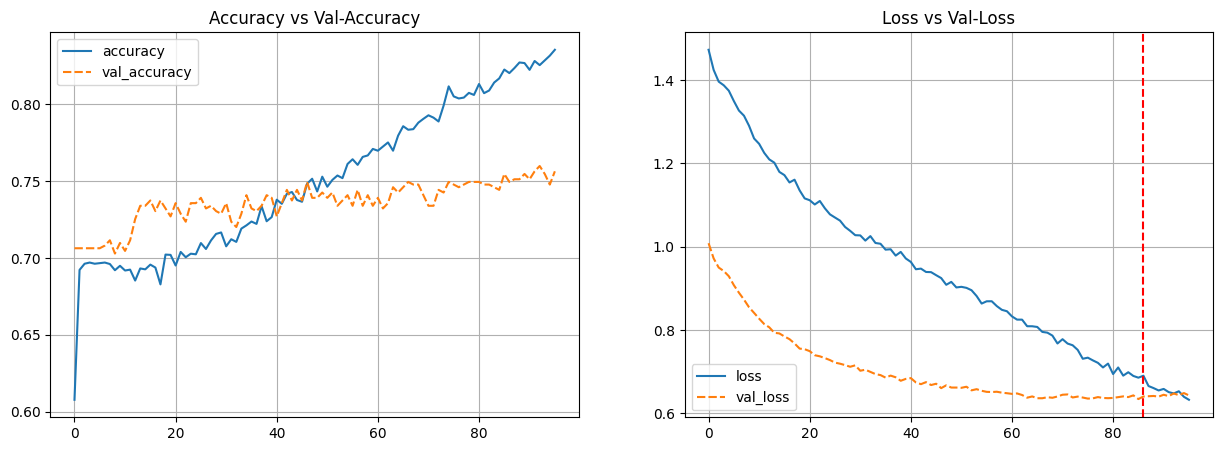

In [51]:
# Plot Training Results
model_2_hist_df = pd.DataFrame(model_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_2_hist_df[['loss', 'val_loss']])
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

From the model, there are improvement after implementing transfer learning and early stopping, the evaluation metrics are greater than before. With transfer learning, we got fitter model. And also, after implementing early stopping, the learning process stops at 96th epoch and the best epoch at 86th epoch with 10 step of patiences. Moreover, because the data is imbalanced, square root weight was suitable for lowering loss. Another improvement is the running time which is shorter than previous model.

As wee can see, the validation loss was plateau so that the training stopped, and the accuracy also fitter and still high.

In [45]:
# Training test set
X_test_array = np.array(X_test, dtype=str)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_array, y_test_ohe)).batch(batch_size)

# Probability predictions (softmax output)
y_pred_1_prob = model_2.predict(test_dataset)

# Convert to class labels
y_pred_1 = np.argmax(y_pred_1_prob, axis=1)

32/32 [==============================] - 1s 39ms/step


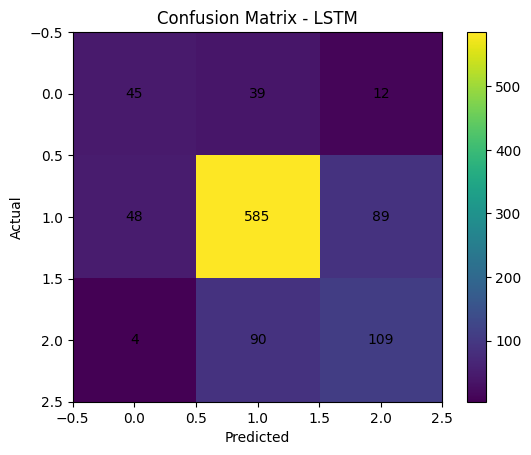

In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_1)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - LSTM")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

In [47]:
# Classification Report
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.46      0.47      0.47        96
           1       0.82      0.81      0.81       722
           2       0.52      0.54      0.53       203

    accuracy                           0.72      1021
   macro avg       0.60      0.61      0.60      1021
weighted avg       0.73      0.72      0.72      1021



To understand the model, we should take a look to the F1-Scores. Our focus is on class 0 and 2, which are more valuable to understand stock price movement. From both score, those are still too low around 0.5. Another analysis was macro average, 0.6, far from the weighted avg. It could be happened because the model is good on predicting class 1 (Neutral) and bad for predicting negative and positive news.

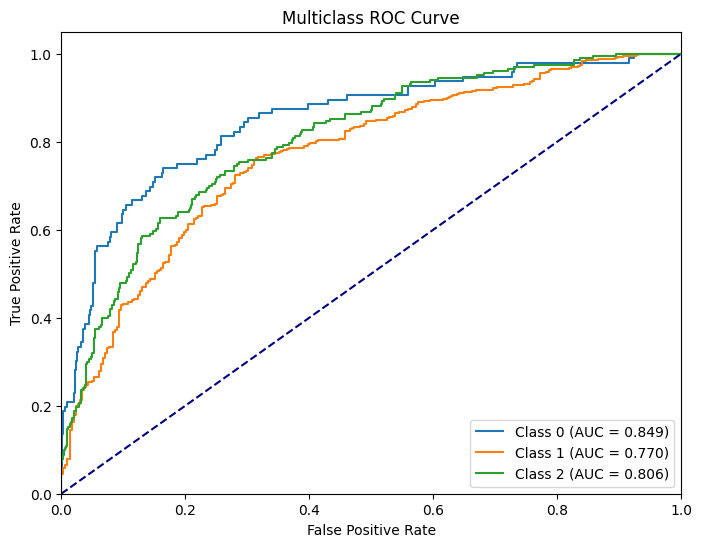

In [54]:
# 1. Binarize y_test to [0, 1, 2]
classes = np.unique(y_test)
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

# Prepare plot
plt.figure(figsize=(8, 6))

# ROC-AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_1_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

Otherwise from F1-Score, negative class had greater AUC score than the others. All class is rangging around 0.8, so that we could say that the model is reliable.

# VIII. Model Saving

In [53]:
# Saving Model
model_2.save('deployment/final_model.keras')

# IX. Conclusion

## A. Summary

From this project, we can conclude:
1. The data is imbalanced of label distribution, which is neutral dominant.
2. From comparing two model, the model using transfer learning and weight setting is better
3. The chosen model showed low F1-Score on Negative and Positive class, and good score on Neutral class
4. The contrary result was presented by AUC Score recording good score.

The final analysis is this model is quite good if we consider more on AUC Score, we could implement it on the deployment as a part of initial suggestion not stock prediction.

## B. Recommedation for Model Improvement

From this project, there are a few further improvement, namely:
1. Try to use bigger dataset for better understanding
2. Try other transfer learning sources for getting comparable insight
3. Try to augment special words to the imbalanced class
4. Try to tuning the threshold because the AUC score is good but F1-Sacore still not convincing.